# Deep Learning Project 2: RoBERTa + LoRA for AG News Classification

## Overview
This notebook implements a text classification model for the AG News dataset using RoBERTa as the base model with Low-Rank Adaptation (LoRA). The goal is to achieve high accuracy while keeping the number of trainable parameters under 1 million as required by the competition rules.

LoRA is a parameter-efficient fine-tuning technique that adds trainable low-rank matrices to frozen pre-trained weights. This allows us to fine-tune large language models with significantly fewer parameters than traditional fine-tuning approaches.

## Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification, RobertaConfig
from peft import LoraConfig, get_peft_model, PeftModel, TaskType
from datasets import load_dataset, Dataset, ClassLabel
import pickle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

/home/ag10687/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Tokenizer and Preprocess Data

In [ ]:
base_model = 'roberta-base'
dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [ ]:
# Extract class info
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")
id2label = {i: label for i, label in enumerate(class_names)}
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Create a custom configuration with increased dropout
config = RobertaConfig.from_pretrained(
    base_model,
    num_labels=num_labels,
    id2label=id2label,
    hidden_dropout_prob=0.05,
)

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model

## Custom RoBERTa Model with Extra Regularization



This class creates a special wrapper around our RoBERTa model that adds extra regularization to help prevent overfitting. Regularization is a technique that helps prevent our model from becoming too specialized to the training data, making it perform better on new, unseen examples.

### Breaking down how it works:

1. **Wrapper Structure**:
   We create a new neural network module that keeps the original RoBERTa model inside it. This lets us add extra functionality without modifying the original model.

2. **Extra Dropout Layer**:
   We add a dropout layer with 20% probability. Dropout is a simple but effective regularization technique that randomly "turns off" a percentage of the neurons during training, forcing the network to be more robust and not rely too heavily on any specific features.

3. **How the Forward Pass Works**:
   - First, we process the input through the original RoBERTa model
   - The output from RoBERTa can be of different types depending on how it's being used
   - If the output already contains prediction scores (logits), we don't modify it
   - If the output contains the final text representation (pooler_output), we:
     - Apply our stronger dropout regularization to it
     - Replace the original representation with our regularized version
   - Then we return the (potentially modified) output



- The extra dropout (20%) targets specifically the final representation before classification
- This strategic regularization helps prevent overfitting by ensuring the model doesn't depend too heavily on specific features
- Since we're fine-tuning with relatively few parameters (using LoRA), this extra regularization is especially important
- This targeted approach is more efficient than simply increasing dropout throughout the entire model
- It helps our model learn more robust patterns that will generalize better to unseen data

In [ ]:
# Load model with custom configuration
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    config=config
)


class RobertaWithExtraRegularization(nn.Module):
    """Custom wrapper for RoBERTa models with additional regularization layers"""

    def __init__(self, base_roberta):
        super(RobertaWithExtraRegularization, self).__init__()

        self.base_model = base_roberta


        self.regularization_layer = nn.Dropout(p=0.2)

    def forward(self, **kwargs):

        model_output = self.base_model(**kwargs)


        if hasattr(model_output, 'logits'):

            return model_output


        if hasattr(model_output, 'pooler_output'):

            representation = model_output.pooler_output

            regularized_representation = self.regularization_layer(representation)

            model_output.pooler_output = regularized_representation

        return model_output

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Anything from here on can be modified

In [ ]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

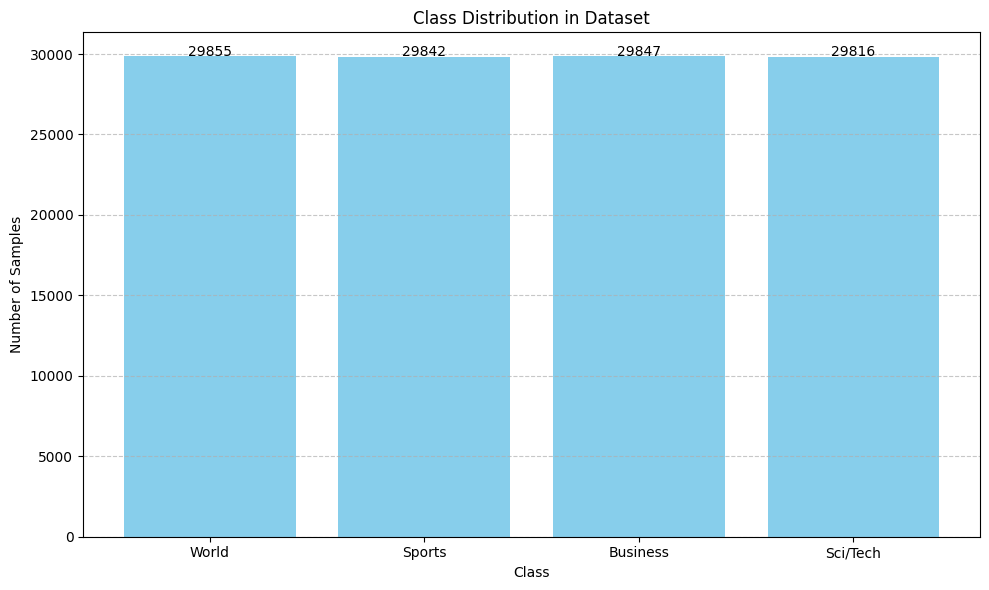

In [ ]:
def plot_class_distribution(dataset, class_names):

    labels = dataset['labels']
    unique_labels, counts = np.unique(labels, return_counts=True)


    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Dataset')
    plt.xticks(unique_labels, class_names)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    for i, count in enumerate(counts):
        plt.text(i, count + 50, str(count), ha='center')

    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=300)
    plt.show()


plot_class_distribution(train_dataset, class_names)

## Setup LoRA Config

Setup PEFT config and get peft model for finetuning

## Understanding the PEFT Configuration

This code sets up a special fine-tuning technique called LoRA (Low-Rank Adaptation) for our RoBERTa model. Let's break down what this means and why it's important:


LoRA is a method that lets us fine-tune a large language model without changing most of its parameters. Instead of modifying all 125 million parameters in RoBERTa, we only add and train small "adapter" matrices to specific parts of the model.

### Key LoRA Settings Explained:

1. **Rank (r=12)**:
   - This determines the size of our adapter matrices
   - Smaller rank = fewer parameters but less expressive power
   - Larger rank = more parameters but more expressive power
   - Value 12 provides a good balance for this task

2. **Alpha (lora_alpha=32)**:
   - Controls how strongly the LoRA adaptations affect the model's behavior
   - Higher values make the adaptations have more impact
   - The ratio alpha/r (32/12) determines the effective learning rate scaling

3. **LoRA Dropout (lora_dropout=0.05)**:
   - Adds a small amount of dropout specifically within the LoRA modules
   - Helps prevent overfitting in our adapter matrices

4. **Bias Training (bias='none')**:
   - We're choosing not to train any bias terms
   - This further reduces parameter count

### Targeted Layers:
Instead of adding adapters everywhere, we're strategically placing them at key points in the model:

- **Early layers** (layers 0-1): Help adapt the model's basic language understanding to our task
  - Query, key, and value matrices in self-attention mechanisms

- **Middle layer** (layer 5): Helps connect low-level features to higher-level understanding
  - Query matrix in self-attention mechanism

- **Late layers** (layers 10-11): Fine-tune the final representations used for classification
  - Query matrix and output dense layer

This strategic targeting achieves better results with fewer parameters than modifying all layers.

### Parameter Efficiency:
When we run `peft_model.print_trainable_parameters()`, we see that:
- We're only training about 796,420 parameters
- This is just 0.63% of the full model's parameters
- This makes training faster, requires less memory, and helps prevent overfitting

By using LoRA with these specific settings, we can efficiently adapt RoBERTa to our news classification task while keeping most of the pre-trained knowledge intact.

In [ ]:
# First, create your base model
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    config=config
)

# Create your PEFT config with corrected target modules
peft_config = LoraConfig(
    r=12,
    lora_alpha=32,
    lora_dropout=0.05,
    bias='none',
    target_modules=["roberta.encoder.layer.0.attention.self.query",
    "roberta.encoder.layer.0.attention.self.key",
    "roberta.encoder.layer.0.attention.self.value",
    "roberta.encoder.layer.1.attention.self.query",
    "roberta.encoder.layer.5.attention.self.query",
    "roberta.encoder.layer.10.attention.self.query",
    "roberta.encoder.layer.10.output.dense",
    "roberta.encoder.layer.11.output.dense"],
    task_type="SEQ_CLS",
)

# Apply PEFT to the enhanced model
print("Applying PEFT adapters to the model...")
peft_model = get_peft_model(model, peft_config)
print("PEFT Model Configuration:")
peft_model.print_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying PEFT adapters to the model...
PEFT Model Configuration:
trainable params: 796,420 || all params: 125,445,128 || trainable%: 0.6349


## Training Setup

In [ ]:
# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Understanding the Training Configuration

The training configuration sets up all the parameters that control how our model learns. Let's explore each setting and why it matters:

### Training Arguments Explained:

 **Output Directory**:
   - `output_dir="./results_deeplearning2"`
   - This is where all model checkpoints and training logs will be saved

 **Learning Rate**:
   - `learning_rate=3e-5` (0.00003)
   - Controls how large each update step is during training
   - This is a careful balance - too high and training becomes unstable, too low and training takes too long
   - 3e-5 is slightly higher than the typical fine-tuning rate, which works well with LoRA

 **Batch Sizes**:
   - `per_device_train_batch_size=16`
   - `per_device_eval_batch_size=32`
   - How many examples the model processes at once
   - Training uses a smaller batch to improve learning, while evaluation uses a larger batch for efficiency
   - Larger batches give more stable gradients but require more memory

 **Training Duration**:
   - `num_train_epochs=5`
   - The model will see the entire training dataset 5 times
   - This provides enough learning iterations without overfitting

 **Weight Decay**:
   - `weight_decay=0.1`
   - This is a regularization technique that penalizes large weights
   - The relatively high value (0.1) provides strong regularization to prevent overfitting
   - Important when using LoRA since we're training fewer parameters

 **Evaluation Strategy**:
   - `eval_strategy="epoch"`
   - The model's performance is evaluated after each complete pass through the data
   - Helps track progress and ensures we're improving
       
 **Save Strategy**:
   - `save_strategy="epoch"`
   - Model checkpoints are saved after each epoch
   - Allows us to recover if training is interrupted

 **Early Stopping**:
   - `load_best_model_at_end=True`
   - Saves the model that performs best on the validation set
   - Prevents overfitting by not necessarily using the model from the final epoch

 **Learning Rate Warmup**:
   - `warmup_ratio=0.15`
   - For the first 15% of training steps, the learning rate gradually increases
   - Helps stabilize early training when gradients might be large

 **Gradient Accumulation**:
    - `gradient_accumulation_steps=2`
    - Updates are performed after accumulating gradients from 2 batches
    - Effectively doubles the batch size without increasing memory requirements
    - Provides more stable updates

 **Learning Rate Schedule**:
    - `lr_scheduler_type="cosine"`
    - The learning rate follows a cosine curve that gradually decreases
    - Allows for larger updates early in training and smaller, more careful updates later
    - Better than linear decay for finding good solutions

 **Optimization Metric**:
    - `metric_for_best_model="accuracy"`
    - The model checkpoint with the highest validation accuracy will be selected as the final model
    - Directly aligns with our goal for the competition




In [ ]:
# Enhanced Training Arguments
print("Defining Training Arguments...")
training_args = TrainingArguments(
    output_dir="./results_deeplearning2",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_dir='./logs_lora_enhanced_dropout',
    logging_steps=100,
    report_to="none",
    warmup_ratio=0.15,
    # bf16=True,
    gradient_accumulation_steps=2,
    lr_scheduler_type="cosine",
    metric_for_best_model="accuracy",
)

# Initialize Trainer
print("Initializing Trainer...")
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Defining Training Arguments...
Initializing Trainer...


/tmp/ipykernel_7949/3403482643.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## Start Training

In [ ]:
# Train the model
result = trainer.train()

/home/ag10687/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.275000,0.297504,0.901563,0.901387,0.902002,0.901563
2,0.258100,0.237984,0.923438,0.923473,0.923703,0.923438
3,0.215900,0.229305,0.929688,0.929643,0.929680,0.929688
4,0.217700,0.225187,0.928125,0.928137,0.928158,0.928125
5,0.220100,0.224663,0.928125,0.928137,0.928158,0.928125


/home/ag10687/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ag10687/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ag10687/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ag10687/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The model demonstrates rapid convergence by Epoch 3, with high and stable accuracy, precision, and recall (~92.9%). The close alignment of precision and recall indicates balanced performance across classes. Minimal improvements after Epoch 3 suggest effective early learning and strong generalization, making additional training unnecessary.

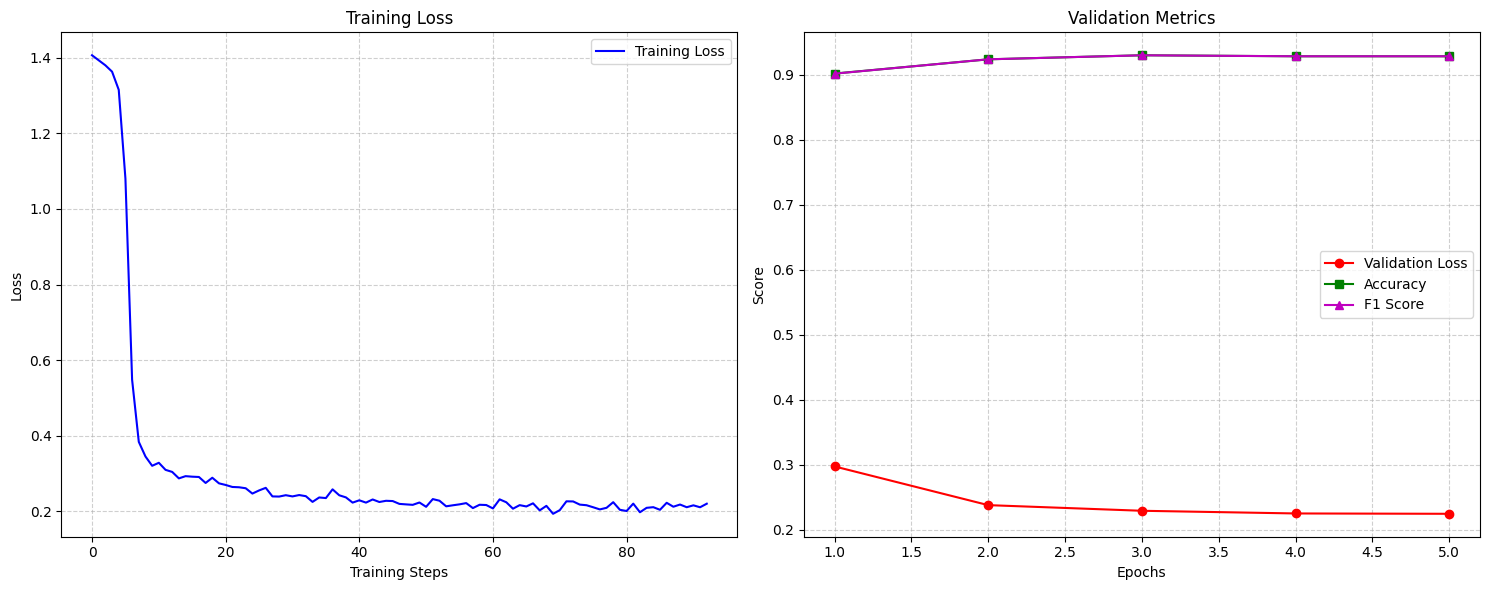

In [ ]:
def plot_training_metrics(trainer):
    """Plot training and evaluation metrics from the Trainer's log history."""

    training_history = trainer.state.log_history


    train_losses = []
    for entry in training_history:
        if 'loss' in entry and 'eval_loss' not in entry:
            train_losses.append(entry['loss'])

    eval_entries = [x for x in training_history if 'eval_loss' in x]
    eval_epochs = [x['epoch'] for x in eval_entries]
    eval_losses = [x['eval_loss'] for x in eval_entries]
    eval_accuracies = [x['eval_accuracy'] for x in eval_entries]
    eval_f1s = [x['eval_f1'] for x in eval_entries]


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


    ax1.plot(range(len(train_losses)), train_losses, 'b-', label='Training Loss')
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)


    ax2.plot(eval_epochs, eval_losses, 'r-', label='Validation Loss', marker='o')
    ax2.plot(eval_epochs, eval_accuracies, 'g-', label='Accuracy', marker='s')
    ax2.plot(eval_epochs, eval_f1s, 'm-', label='F1 Score', marker='^')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Score')
    ax2.set_title('Validation Metrics')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_training_metrics(trainer)

The training loss graph shows a steep decline within the first few steps, indicating rapid learning early in training. It then gradually plateaus, suggesting stable convergence. In the validation metrics graph, both accuracy and F1 score remain consistently high across epochs, while validation loss decreases steadily. This indicates strong generalization, balanced performance, and no signs of overfitting.

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [ ]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [ ]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [ ]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:05<00:00, 15.81it/s]

Evaluation Metric: {'accuracy': 0.9296875}


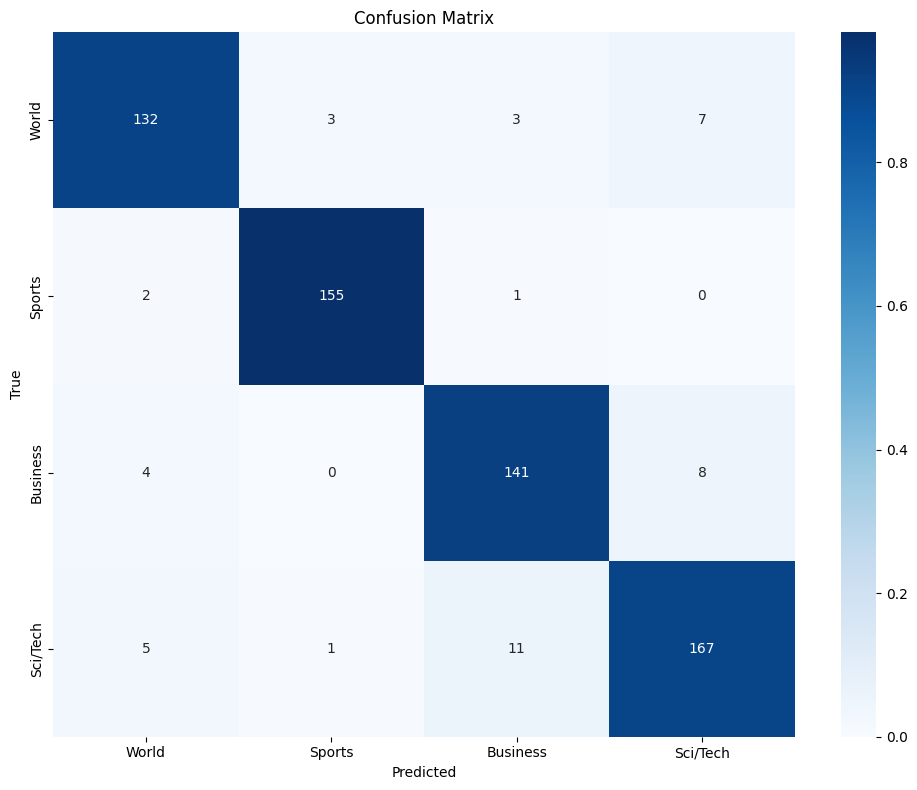

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataset, data_collator, class_names):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()


    dataloader = DataLoader(dataset, batch_size=8, collate_fn=data_collator)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = outputs.logits.argmax(dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())


    cm = confusion_matrix(all_labels, all_preds)


    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    return cm


cm = plot_confusion_matrix(peft_model, eval_dataset, data_collator, class_names)

### Run Inference on unlabelled dataset

In [ ]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map: 100%|██████████| 8000/8000 [00:06<00:00, 1309.02 examples/s]


Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:

output_dir = "./results_deeplearning2"


preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})


df_output.to_csv(os.path.join(output_dir, "inference_outputdeepleraning.csv"), index=False)
print("Inference complete. Predictions saved to inference_outputdeeplearning.csv")


100%|██████████| 1000/1000 [00:45<00:00, 21.95it/s]


Inference complete. Predictions saved to inference_outputdeeplearning.csv


The CSV file contains `ID` and `Label` columns and is submitted to Kaggle, where we achieve an accuracy of **85.575\% on the full (100\%) test set** and **85.825\% on the public (50\%) test split**. The slight decrease in accuracy on the full dataset indicates that the model may be slightly overfitting to the validation set or that the private portion of the test set contains more challenging or diverse samples, highlighting the importance of generalization in model performance.

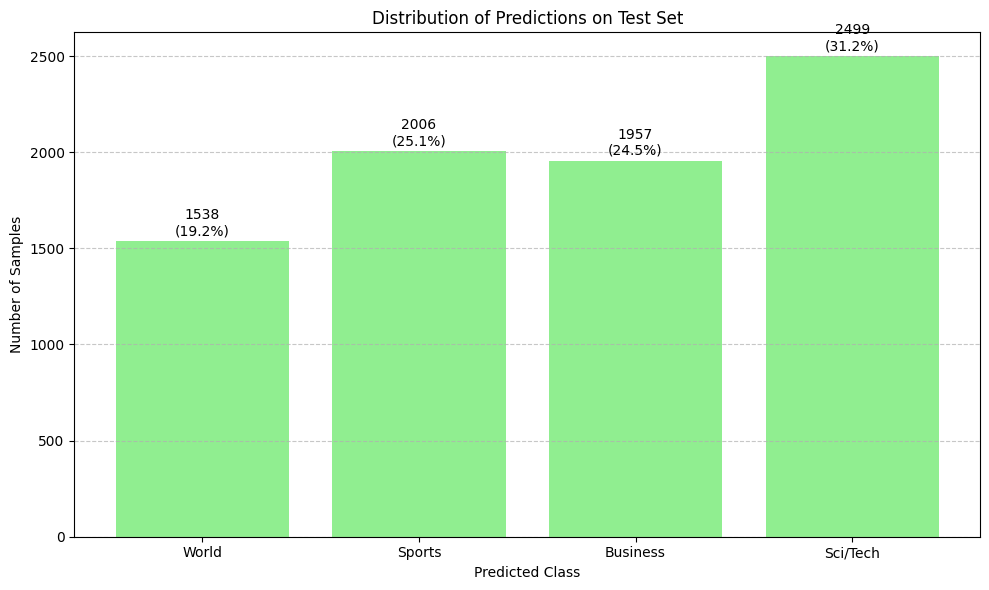

In [ ]:
def plot_prediction_distribution(predictions, class_names):
    """Plot the distribution of predictions on the test set."""

    pred_counts = np.bincount(predictions)

    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(pred_counts)), pred_counts, color='lightgreen')

    # Add labels and title
    plt.xlabel('Predicted Class')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Predictions on Test Set')
    plt.xticks(range(len(class_names)), class_names)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add count and percentage labels on bars
    total = sum(pred_counts)
    for i, bar in enumerate(bars):
        count = pred_counts[i]
        percentage = count / total * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                f'{count}\n({percentage:.1f}%)', ha='center')

    plt.tight_layout()
    plt.savefig('prediction_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

all_predictions = df_output['Label'].values  # Use the saved predictions
plot_prediction_distribution(all_predictions, class_names)

This bar chart shows the distribution of model predictions across the four AG News categories on the test set. The Sci/Tech category is the most predicted (31.2%), while World is the least (19.2%), indicating a potential class imbalance in predictions. Sports and Business categories have similar and more balanced prediction counts at around 25%. The skew toward Sci/Tech may suggest the model is more confident or biased toward identifying articles in that category, which could warrant further investigation into label distribution or feature overlap among classes.